In [116]:
# Load packages
import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [117]:
path = 'C:/Users/angel/Documents/Economics/Research/Banking Project/data/intermediate/call_reports_SP/'

# Set path to be the directory:
os.chdir(path)

In [118]:
#df = pd.concat([pd.read_csv(f) for f in os.listdir() if f.endswith('.csv')])
#df = df.iloc[:, 0:270]
#df['Date'] = df['Date'].astype(str)
#df['Month'] = np.where(df['Date'].str.len() == 8, df['Date'].str[0:2], '0'+df['Date'].str[0])
#df['Day'] = df['Date'].str[-6:-4]
#df['Year'] = df['Date'].str[-4:]
#df['Date'] = pd.to_datetime(df['Year'] + '-' + df['Month'] + '-' + df['Day'])
#df.to_csv(path + 'call_reports.csv', index = False)

In [119]:
# Read file that contains only the variables of interest, specify that the column 'Date' is a date:
df = pd.read_csv('call_reports.csv', parse_dates = ['Date'])

C:\Users\angel\AppData\Local\Temp\ipykernel_19264\1849562282.py:2: DtypeWarning: Columns (102,146,187,228) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('call_reports.csv', parse_dates = ['Date'])


In [120]:
# create a 'Year' variable:
df['Year'] = df['Date'].dt.year

### Deposits

In [121]:
# Create a new column that will contain the deposit expenditure it will sum 'RIADA517', 'RIADA518', 'RIAD4508', 'RIAD0093' for
# any date before 2017:
df['Deposit Expenditure'] = np.where(df['Date'] < '2017-01-01', df['RIADA517']+df['RIADA518']+df['RIAD4508']+df['RIAD0093'], 
                                     df['RIADHK03']+df['RIADHK04']+df['RIAD4508']+df['RIAD0093'])

In [122]:
# Group by 'ID' and compute the difference in 'Deposit_Expenditure' to get the actual expenditure per period
df['Actual Expenditure'] = df.groupby(['IDRSSD', 'Year'])['Deposit Expenditure'].diff().fillna(df['Deposit Expenditure'])

In [123]:
df['Total Deposit'] = np.where(df['Date'] < '2017-01-01', df['RCON3485']+df['RCONB563']+df['RCONA514']+df['RCONA529'], 
                                     df['RCON3485']+df['RCONB563']+df['RCONHK16']+df['RCONHK17'])

In [124]:
df = df[df['Total Deposit']>0]

In [125]:
df['Deposit Rate'] = df['Actual Expenditure'] / df['Total Deposit']

In [126]:
# Average the deposit rate by 'Date', weighting by 'Total Deposit':
df['Weighted Deposit Rate'] = df.groupby('Date')['Deposit Rate'].transform(lambda x: np.average(x, weights = df.loc[x.index, 'Total Deposit']))

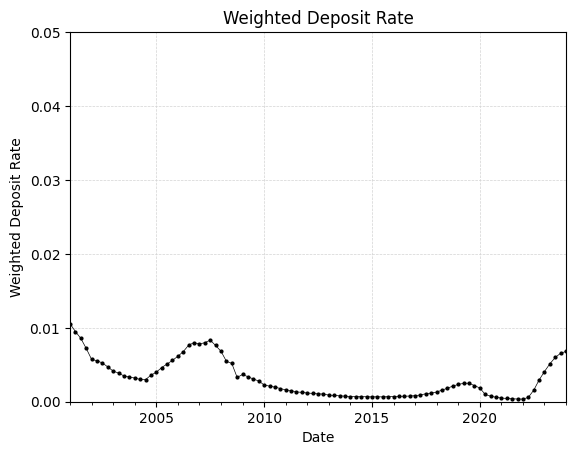

In [127]:
# plot the weighted deposit rate by date in a way we have only one observation per date:
df[['Date', 'Weighted Deposit Rate']].sort_values('Date').drop_duplicates('Date').set_index('Date').plot(marker='o', color='black', markersize=2, linewidth=0.5)
plt.ylim(0, 0.05)
plt.xlabel('Date')
plt.ylabel('Weighted Deposit Rate')
plt.title('Weighted Deposit Rate')
plt.legend().remove()
plt.grid(color = 'lightgray', linestyle = '--', linewidth = 0.5)
plt.show()


In [128]:
# Create an extra column in df3 with the avg. deposit rate per Date:
df['Avg. Deposit Rate'] = df.groupby('Date')['Deposit Rate'].transform('mean')
df['Std. Deposit Rate'] = df.groupby('Date')['Deposit Rate'].transform('std')

In [129]:
df['R_hat'] = (df['Deposit Rate'] - df['Avg. Deposit Rate']) / df['Std. Deposit Rate']

In [130]:
# Until here, dataset matches with Lucas.
#df2[(df2['Date']>'2023-01-01') & (df2['Date']<'2024-01-01')]['Deposit Rate'].describe()

##### Distribution of deposit rates

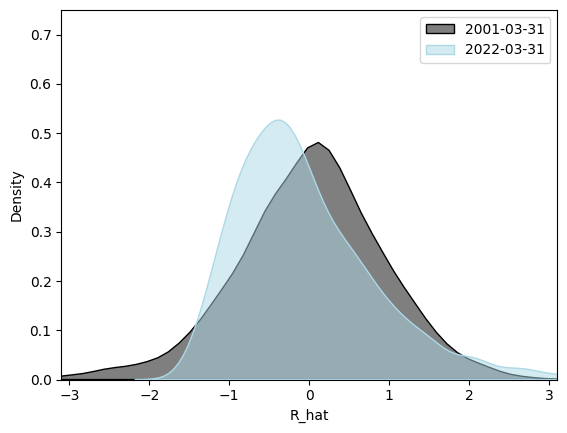

In [131]:
# plot the kernel distribution of the deposit rates for the above dates:
sns.kdeplot(df[df['Date']=='2001-03-31']['R_hat'], label='2001-03-31', color='black', fill=True, alpha=0.5)
sns.kdeplot(df[df['Date']=='2022-03-31']['R_hat'], label='2022-03-31', color='lightblue', fill=True, alpha=0.5)
plt.xlim(-3.1, 3.1)
plt.ylim(0, 0.75)
plt.legend()
plt.show()

C:\Users\angel\AppData\Local\Temp\ipykernel_19264\4265616815.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_bottom = df.groupby('Date').apply(lambda x: x[x['Total Deposit'] <= x['Total Deposit'].quantile(0.1)]).reset_index(drop=True)


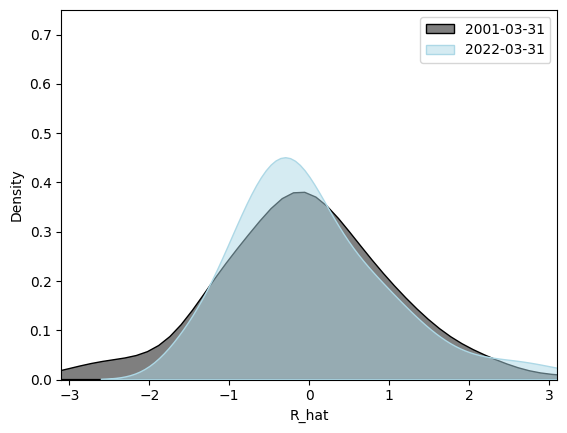

In [132]:
df_bottom = df.groupby('Date').apply(lambda x: x[x['Total Deposit'] <= x['Total Deposit'].quantile(0.1)]).reset_index(drop=True)

# plot the kernel distribution of the deposit rates for the above dates:
sns.kdeplot(df_bottom[df_bottom['Date']=='2001-03-31']['R_hat'], label='2001-03-31', color='black', fill=True, alpha=0.5)
sns.kdeplot(df_bottom[df_bottom['Date']=='2022-03-31']['R_hat'], label='2022-03-31', color='lightblue', fill=True, alpha=0.5)
#Adjust the x-axis to be able to see the distribution better:
plt.xlim(-3.1, 3.1)
plt.ylim(0, 0.75)
plt.legend()
plt.show()

C:\Users\angel\AppData\Local\Temp\ipykernel_19264\3550706794.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_top = df.groupby('Date').apply(lambda x: x[x['Total Deposit'] >= x['Total Deposit'].quantile(0.9)]).reset_index(drop=True)


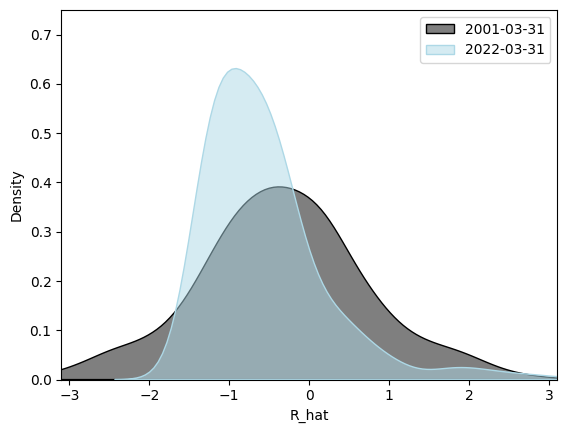

In [133]:
df_top = df.groupby('Date').apply(lambda x: x[x['Total Deposit'] >= x['Total Deposit'].quantile(0.9)]).reset_index(drop=True)

# plot the kernel distribution of the deposit rates for the above dates:
sns.kdeplot(df_top[df_top['Date']=='2001-03-31']['R_hat'], label='2001-03-31', color='black', fill=True, alpha=0.5)
sns.kdeplot(df_top[df_top['Date']=='2022-03-31']['R_hat'], label='2022-03-31', color='lightblue', fill=True, alpha=0.5)
plt.xlim(-3.1, 3.1)
plt.ylim(0, 0.75)
plt.legend()
plt.show()

##### Where does this dispersion is coming from?

In [134]:
df['Insured TD'] = np.where(df['Date'] < '2017-01-01', df['RIADA518'], df['RIADHK03']) 
df['Insured TD Exp'] = np.where(df['Date'] < '2017-01-01', df['RCONA529'], df['RCONHK16'])
df['Uninsured TD'] = np.where(df['Date'] < '2017-01-01', df['RIADA517'], df['RIADHK04']) 
df['Uninsured TD Exp'] = np.where(df['Date'] < '2017-01-01', df['RCONA514'], df['RCONHK17'])

In [135]:
df['Actual Insured TD Exp'] = df.groupby(['IDRSSD', 'Year'])['Insured TD Exp'].diff().fillna(df['Insured TD Exp'])
df['Actual Uninsured TD Exp'] = df.groupby(['IDRSSD', 'Year'])['Uninsured TD Exp'].diff().fillna(df['Uninsured TD Exp'])

In [136]:
df['Savings Rate'] = df.groupby(['IDRSSD', 'Year'])['RIAD0093'].diff().fillna(df['RIAD0093']) / df['RCONB563']
df['Uninsured TD Rate'] = df['Actual Uninsured TD Exp'] / df['Uninsured TD']
df['Insured TD Rate'] =   df['Actual Insured TD Exp'] / df['Insured TD']

In [137]:
# Create an extra column in df3 with the avg. deposit rate per Date:
df2 = df[(df['RCONB563']>0) & (df['Insured TD']>0) & (df['Uninsured TD']>0)].copy()

# Trim the top 1% and bottom 1% of 'Total Deposit' per year:
df2 = df2.groupby('Year').apply(lambda x: x[(x['RCONB563'] >= x['RCONB563'].quantile(0.01)) & (x['RCONB563'] <= x['RCONB563'].quantile(0.99))]).reset_index(drop=True)

C:\Users\angel\AppData\Local\Temp\ipykernel_19264\4016987120.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df2 = df2.groupby('Year').apply(lambda x: x[(x['RCONB563'] >= x['RCONB563'].quantile(0.01)) & (x['RCONB563'] <= x['RCONB563'].quantile(0.99))]).reset_index(drop=True)


In [138]:
df2['Avg. Savings Rate'] = df2.groupby('Date')['Savings Rate'].transform('mean')
df2['Std. Savings Rate'] = df2.groupby('Date')['Savings Rate'].transform('std')
df2['Savings_hat'] = (df2['Savings Rate'] - df2['Avg. Savings Rate']) #/ df2['Std. Savings Rate']

In [141]:
df3 = df[(df['RCONB563']>0) & (df['Insured TD']>0) & (df['Uninsured TD']>0)].copy()
df3 = df3.groupby('Year').apply(lambda x: x[(x['Insured TD'] >= x['Insured TD'].quantile(0.01)) & (x['Insured TD'] <= x['Insured TD'].quantile(0.99))]).reset_index(drop=True)

C:\Users\angel\AppData\Local\Temp\ipykernel_19264\2779775023.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df3 = df3.groupby('Year').apply(lambda x: x[(x['Insured TD'] >= x['Insured TD'].quantile(0.01)) & (x['Insured TD'] <= x['Insured TD'].quantile(0.99))]).reset_index(drop=True)


In [142]:
df3['Avg. Insured TD Rate'] = df3.groupby('Date')['Insured TD Rate'].transform('mean')
df3['Std. Insured TD Rate'] = df3.groupby('Date')['Insured TD Rate'].transform('std')
df3['Insured_TD_hat'] = (df3['Insured TD Rate'] - df3['Avg. Insured TD Rate']) #/ df3['Std. Insured TD Rate']

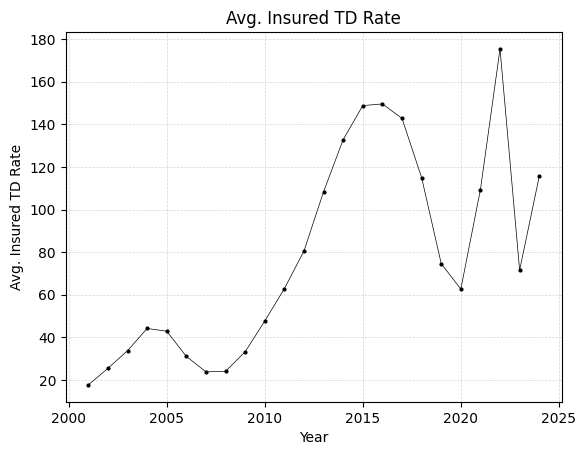

In [152]:
# plot the Avg. Insured TD Rate per year:
df3.groupby('Year')['Avg. Insured TD Rate'].mean().plot(marker='o', color='black', markersize=2, linewidth=0.5)
plt.xlabel('Year')
plt.ylabel('Avg. Insured TD Rate')
plt.title('Avg. Insured TD Rate')
plt.legend().remove()
plt.grid(color = 'lightgray', linestyle = '--', linewidth = 0.5)
plt.show()

In [151]:
df4 = df[(df['RCONB563']>0) & (df['Insured TD']>0) & (df['Uninsured TD']>0)].copy()
df4 = df4.groupby('Year').apply(lambda x: x[(x['Uninsured TD'] >= x['Uninsured TD'].quantile(0.01)) & (x['Uninsured TD'] <= x['Uninsured TD'].quantile(0.99))]).reset_index(drop=True)

C:\Users\angel\AppData\Local\Temp\ipykernel_19264\1165851417.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df4 = df4.groupby('Year').apply(lambda x: x[(x['Uninsured TD'] >= x['Uninsured TD'].quantile(0.01)) & (x['Uninsured TD'] <= x['Uninsured TD'].quantile(0.99))]).reset_index(drop=True)


In [ ]:
df4['Avg. Uninsured TD Rate'] = df[df['Uninsured TD']>0].groupby('Date')['Uninsured TD Rate'].transform('mean')
df4['Std. Uninsured TD Rate'] = df[df['Uninsured TD']>0].groupby('Date')['Uninsured TD Rate'].transform('std')
df4['Uninsured_TD_hat'] = (df4['Uninsured TD Rate'] - df4['Avg. Uninsured TD Rate']) #/ df4['Std. Uninsured TD Rate']

<Axes: xlabel='Year'>

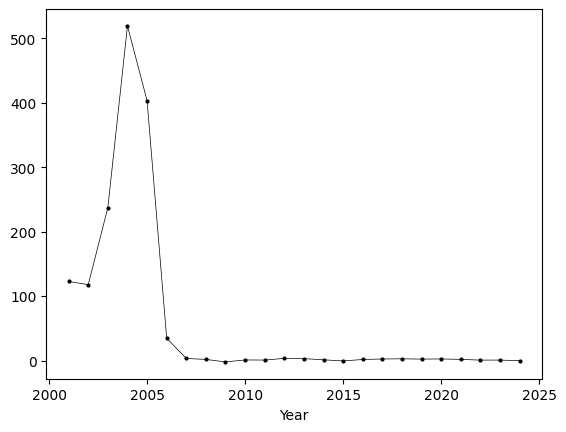

In [ ]:
df4.groupby('Year')['Avg. Uninsured TD Rate'].mean().plot(marker='o', color='black', markersize=2, linewidth=0.5)

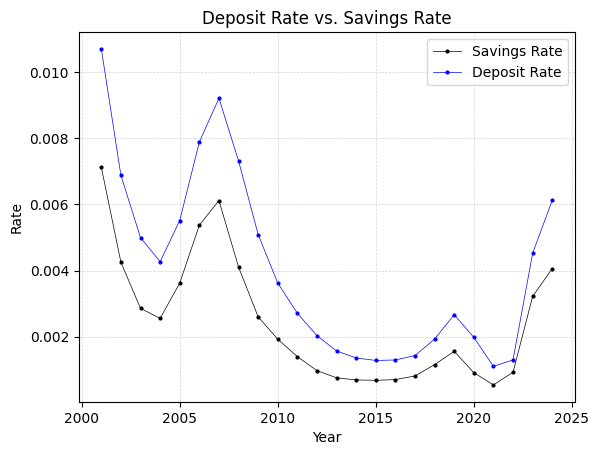

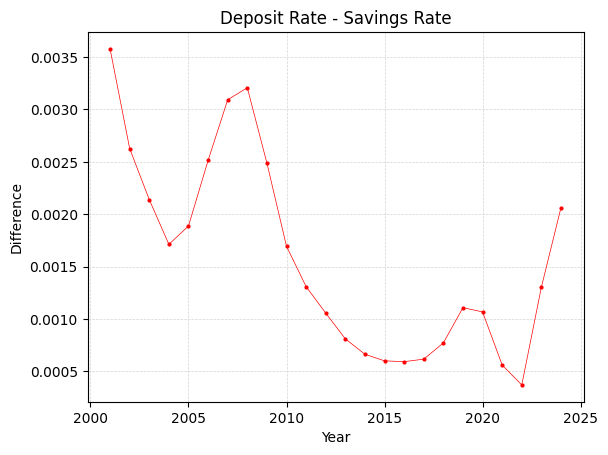

In [155]:
# plot the raw average deposit rate with the raw average savings rate:
df2.groupby('Year')['Savings Rate'].mean().plot(marker='o', color='black', markersize=2, linewidth=0.5)
df2.groupby('Year')['Deposit Rate'].mean().plot(marker='o', color='blue', markersize=2, linewidth=0.5)
plt.xlabel('Year')
plt.ylabel('Rate')
plt.title('Deposit Rate vs. Savings Rate')
plt.legend(['Savings Rate', 'Deposit Rate'])
plt.grid(color = 'lightgray', linestyle = '--', linewidth = 0.5)
plt.show()


# also plot the difference between the two rates:
(df2.groupby('Year')['Deposit Rate'].mean() - df2.groupby('Year')['Savings Rate'].mean()).plot(marker='o', color='red', markersize=2, linewidth=0.5)
plt.xlabel('Year')
plt.ylabel('Difference')
plt.title('Deposit Rate - Savings Rate')
plt.grid(color = 'lightgray', linestyle = '--', linewidth = 0.5)
plt.show()



### Loans and Assets

In [ ]:
# Check total Interest Income:
df['Interest Income'] = df['RIAD4107']
# Check Total Assets:
df['Total Assets'] = df['RCFD2170']
df['ROA'] = df['Interest Income'] / df['Total Assets']

In [ ]:
df = df[df['Total Assets']>0]

In [ ]:
# Create an extra column in df3 with the avg. deposit rate per Date:
df['Avg. ROA'] = df.groupby('Date')['ROA'].transform('mean')
df['Std. ROA'] = df.groupby('Date')['ROA'].transform('std')

In [ ]:
df['ROA_hat'] = (df['ROA'] - df['Avg. ROA']) / df['Std. ROA']

In [ ]:
# plot the kernel distribution of the ROA for the above dates:
sns.kdeplot(df[df['Date']=='2001-03-31']['ROA_hat'], label='2001', color='black', fill=True, alpha=0.5)
sns.kdeplot(df[df['Date']=='2022-03-31']['ROA_hat'], label='2022', color='lightblue', fill=True, alpha=0.5)
plt.legend()
plt.show()